# GeMpy

In [1]:
import sys
sys.path.append("../")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

In [2]:
geo_data = gp.read_pickle("../input_data/BasicFault.pickle")
geo_data.n_faults = 1

In [3]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault
0,800.0,1000.0,-1600.0,MainFault,fault,1,True
1,1000.0,1000.0,-1000.0,MainFault,fault,1,True
2,1200.0,1000.0,-400.0,MainFault,fault,1,True
3,1100.0,1000.0,-700.0,MainFault,fault,1,True
4,900.0,1000.0,-1300.0,MainFault,fault,1,True


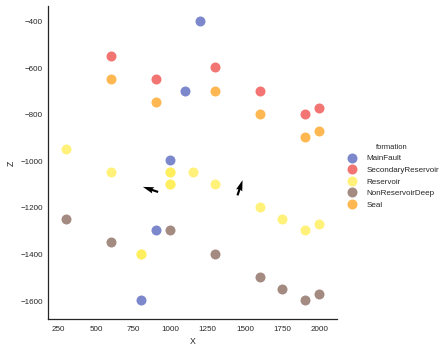

In [4]:
geo_data.geo_data_type = 'whatever'
gp.plot_data(geo_data, direction='y')

In [5]:
# stdev for x,y,z interface coordinates
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = None
geo_data.interfaces['Z_std'] = 100
geo_data.interfaces['dist_type'] = "Normal" # should be initially None
geo_data.interfaces['X_dist'] = None
geo_data.interfaces['Y_dist'] = None
geo_data.interfaces['Z_dist'] = None

#geo_data.foliations['X_std'] = None
#geo_data.foliations['Y_std'] = 0
#geo_data.foliations['Z_std'] = 0

In [6]:
geo_data.interfaces

,X,Y,Z,formation,series,order_series,isFault,X_std,Y_std,Z_std,dist_type,X_dist,Y_dist,Z_dist
0,800.0,1000.0,-1600.0,MainFault,fault,1,True,None,None,100,Normal,None,None,None
1,1000.0,1000.0,-1000.0,MainFault,fault,1,True,None,None,100,Normal,None,None,None
2,1200.0,1000.0,-400.0,MainFault,fault,1,True,None,None,100,Normal,None,None,None
3,1100.0,1000.0,-700.0,MainFault,fault,1,True,None,None,100,Normal,None,None,None
4,900.0,1000.0,-1300.0,MainFault,fault,1,True,None,None,100,Normal,None,None,None
5,1900.0,1000.0,-800.0,SecondaryReservoir,Rest,2,False,None,None,100,Normal,None,None,None
6,1300.0,1000.0,-600.0,SecondaryReservoir,Rest,2,False,None,None,100,Normal,None,None,None
7,600.0,1000.0,-550.0,SecondaryReservoir,Rest,2,False,None,None,100,Normal,None,None,None
8,1000.0,1900.0,-1100.0,Reservoir,Rest,2,False,None,None,100,Normal,None,None,None
9,1000.0,1975.0,-1050.0,Reservoir,Rest,2,False,None,None,100,Normal,None,None,None


In [7]:
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

[2, 2]


In [8]:
sol = gp.compute_model(interp_data)

[3, 3]


In [9]:
interp_data.potential_at_interfaces

array([[-0.55960631,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.43870384,  0.30235174,  0.22210455,  0.41619769]], dtype=float32)

adding dataframe columns for uncertainty analysis

### Create pymc.Distribution objects for each stochastic value and put into df

In [10]:
interp_data.geo_data_res.interfaces['Z'].shape

(39,)

In [11]:
Z_unc = []
for i in range(39):
    Z_unc.append(pymc.Normal('Z_unc'+str(i),
           interp_data.geo_data_res.interfaces['Z'].iloc[i].astype('float32'),
           1./interp_data.geo_data_res.interfaces['Z_std'].iloc[i].astype('float32')))


### Create pymc.Model

In [44]:



@pymc.deterministic
def gempy_model(value=0, input_ =  Z_unc):
          #xp = X_priors, yp = Y_priors, zp = Z_priors, ref = data_ref):
    
    interp_data.geo_data_res.interfaces['Z'] = Z_unc
    
    i = interp_data.get_input_data()
    
    sol, pot = interp_data.th_fn(*i)
    print(i)
    print(sol[0,0,:])
    # return solution
    return sol


[3, 3]
[array([[ 0.4404718 ,  0.50010002,  0.46538258],
       [ 0.57702309,  0.50010002,  0.46163845]], dtype=float32), array([ 71.56500244,  18.43499947], dtype=float32), array([ 270.,   90.], dtype=float32), array([ 1.,  1.], dtype=float32), array([[ 0.4103564 ,  0.50010002,  0.22156855],
       [ 0.4103564 ,  0.50010002,  0.22156855],
       [ 0.4103564 ,  0.50010002,  0.22156855],
       [ 0.4103564 ,  0.50010002,  0.22156855],
       [ 0.69240767,  0.50010002,  0.60398644],
       [ 0.69240767,  0.50010002,  0.60398644],
       [ 0.69240767,  0.50010002,  0.60398644],
       [ 0.69240767,  0.50010002,  0.60398644],
       [ 0.69240767,  0.50010002,  0.60398644],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  0.53424203],
       [ 0.46163845,  0.73086923,  

In [15]:
# set number of iterations
iterations = 10

In [45]:

# set model
pymc_model = pymc.Model([interp_data, gempy_model, *Z_unc, a, interp_data])

### MCFS

In [46]:
MCFS_RUN = pymc.MCMC(pymc_model)
MCFS_RUN.sample(iter=iterations)

[3, 3]
[array([[ 0.4404718 ,  0.50010002,  0.46538258],
       [ 0.57702309,  0.50010002,  0.46163845]], dtype=float32), array([ 71.56500244,  18.43499947], dtype=float32), array([ 270.,   90.], dtype=float32), array([ 1.,  1.], dtype=float32), array([[ 0.4103564 ,  0.50010002,  0.46939006],
       [ 0.4103564 ,  0.50010002,  0.46939006],
       [ 0.4103564 ,  0.50010002,  0.46939006],
       [ 0.4103564 ,  0.50010002,  0.46939006],
       [ 0.69240767,  0.50010002,  0.5181852 ],
       [ 0.69240767,  0.50010002,  0.5181852 ],
       [ 0.69240767,  0.50010002,  0.5181852 ],
       [ 0.69240767,  0.50010002,  0.5181852 ],
       [ 0.69240767,  0.50010002,  0.5181852 ],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  0.37164363],
       [ 0.46163845,  0.73086923,  

 [---------------  40%                  ] 4 of 10 complete in 7.0 sec[3, 3]
[array([[ 0.4404718 ,  0.50010002,  0.46538258],
       [ 0.57702309,  0.50010002,  0.46163845]], dtype=float32), array([ 71.56500244,  18.43499947], dtype=float32), array([ 270.,   90.], dtype=float32), array([ 1.,  1.], dtype=float32), array([[ 0.4103564 ,  0.50010002,  0.41944689],
       [ 0.4103564 ,  0.50010002,  0.41944689],
       [ 0.4103564 ,  0.50010002,  0.41944689],
       [ 0.4103564 ,  0.50010002,  0.41944689],
       [ 0.69240767,  0.50010002,  0.50477546],
       [ 0.69240767,  0.50010002,  0.50477546],
       [ 0.69240767,  0.50010002,  0.50477546],
       [ 0.69240767,  0.50010002,  0.50477546],
       [ 0.69240767,  0.50010002,  0.50477546],
       [ 0.46163845,  0.73086923,  0.38847107],
       [ 0.46163845,  0.73086923,  0.38847107],
       [ 0.46163845,  0.73086923,  0.38847107],
       [ 0.46163845,  0.73086923,  0.38847107],
       [ 0.46163845,  0.73086923,  0.38847107],
       [ 0.461

 [-----------------70%------            ] 7 of 10 complete in 14.1 sec[3, 3]
[array([[ 0.4404718 ,  0.50010002,  0.46538258],
       [ 0.57702309,  0.50010002,  0.46163845]], dtype=float32), array([ 71.56500244,  18.43499947], dtype=float32), array([ 270.,   90.], dtype=float32), array([ 1.,  1.], dtype=float32), array([[ 0.4103564 ,  0.50010002,  0.21167067],
       [ 0.4103564 ,  0.50010002,  0.21167067],
       [ 0.4103564 ,  0.50010002,  0.21167067],
       [ 0.4103564 ,  0.50010002,  0.21167067],
       [ 0.69240767,  0.50010002,  0.56742787],
       [ 0.69240767,  0.50010002,  0.56742787],
       [ 0.69240767,  0.50010002,  0.56742787],
       [ 0.69240767,  0.50010002,  0.56742787],
       [ 0.69240767,  0.50010002,  0.56742787],
       [ 0.46163845,  0.73086923,  0.32129416],
       [ 0.46163845,  0.73086923,  0.32129416],
       [ 0.46163845,  0.73086923,  0.32129416],
       [ 0.46163845,  0.73086923,  0.32129416],
       [ 0.46163845,  0.73086923,  0.32129416],
       [ 0.46

 [-----------------100%-----------------] 10 of 10 complete in 20.7 sec[3, 3]
[array([[ 0.4404718 ,  0.50010002,  0.46538258],
       [ 0.57702309,  0.50010002,  0.46163845]], dtype=float32), array([ 71.56500244,  18.43499947], dtype=float32), array([ 270.,   90.], dtype=float32), array([ 1.,  1.], dtype=float32), array([[ 0.4103564 ,  0.50010002,  0.60020614],
       [ 0.4103564 ,  0.50010002,  0.60020614],
       [ 0.4103564 ,  0.50010002,  0.60020614],
       [ 0.4103564 ,  0.50010002,  0.60020614],
       [ 0.69240767,  0.50010002,  0.68271482],
       [ 0.69240767,  0.50010002,  0.68271482],
       [ 0.69240767,  0.50010002,  0.68271482],
       [ 0.69240767,  0.50010002,  0.68271482],
       [ 0.69240767,  0.50010002,  0.68271482],
       [ 0.46163845,  0.73086923,  0.71295309],
       [ 0.46163845,  0.73086923,  0.71295309],
       [ 0.46163845,  0.73086923,  0.71295309],
       [ 0.46163845,  0.73086923,  0.71295309],
       [ 0.46163845,  0.73086923,  0.71295309],
       [ 0.4

In [37]:
MCFS_RUN.trace("Z_unc3")[:]

array([ 0.50956345,  0.44646652,  0.56562862,  0.86983638,  0.45895468,
        0.42327487,  0.58645743,  0.42703272,  0.38792071,  0.90895515])

In [81]:
MCFS_RUN.summary()

/home/miguel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)



gempy_model:
 


KeyboardInterrupt: 

In [78]:
import matplotlib.pyplot as plt

In [11]:
Z_rest = pymc.Normal('Z_unc_rest',  interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'))

Z_ref = pymc.Normal('Z_unc_ref',  interp_data.interpolator.pandas_ref_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_ref_layer_points['Z_std'].as_matrix().astype('float32'))


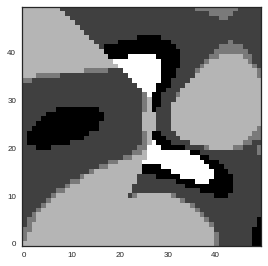

In [21]:
plt.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[2][0, 0, :].reshape(50,50,50)[:,24,:].T, origin="lower")